In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle
from tensorflow import keras
from tensorflow.keras.models import save_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, classification_report, roc_auc_score
from IPython.display import display, HTML
from xgboost import XGBClassifier
from sklearn.utils import class_weight
import os
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


In [2]:
GENERAL_DIET_AND_HEALTH_KEYWORDS = {
    'Dietary Restrictions': [
        'vegetarian', 'vegan', 'dairy free foods', 'egg free', 'lactose free',
        'no shell fish', 'free of...'
    ],
    'Health Focus': [
        'low calorie', 'healthy', 'light', 'low cholesterol', 'low protein',
        'very low carbs', 'high fiber', 'high protein', 'protein'
    ]
}

GENERAL_COOKING_AND_EQUIPMENT_KEYWORDS = {
    'Cooking Methods': [
        'no cook', 'stove top', 'oven', 'baking', 'broil/grill', 'microwave',
        'pressure cooker', 'deep fried', 'steam', 'stir fry', 'wok'
    ],
    'Equipment': [
        'small appliance', 'mixer', 'dehydrator', 'refrigerator', 'freezer',
        'bread machine'
    ]
}

GENERAL_MEAL_AND_TIME_KEYWORDS = {
    'Meal Type': [
        'breakfast', 'brunch', 'lunchsnacks', 'one dish meal', 'stew',
        'pot roast', 'meatloaf', 'dessert', 'frozen desserts', 'ice cream',
        'cheesecake', 'bar cookie', 'drop cookies', 'chocolate chip cookies',
        'cake', 'chowders', 'clear soup', 'beef barley soup', 'mushroom soup',
        'pasta shells', 'penne', 'spaghetti', 'macaroni and cheese', 'manicotti',
        'pasta elbow', 'breads', 'quick breads', 'yeast breads',
        'sourdough breads', 'savory pies', 'pie', 'cookie & brownie',
        'beverages', 'punch beverage', 'smoothies', 'shakes', 'sauces',
        'chutneys', 'spreads', 'side dish', 'accompaniment', 'garnish',
        'coleslaw', 'potato salad'
    ],
    'Time & Budget': [
        '< 15 mins', '< 30 mins', '< 60 mins', '< 4 hours', 'weeknight',
        'inexpensive'
    ]
}

GENERAL_INGREDIENT_KEYWORDS = {
    'Proteins & Produce': [
        'chicken', 'beef', 'pork', 'duck', 'goose', 'turkey', 'veal', 'rabbit',
        'lamb/sheep', 'quail', 'deer', 'moose', 'elk', 'pheasant', 'wild game',
        'fish', 'seafood', 'salmon', 'tuna', 'halibut', 'bass', 'catfish',
        'tilapia', 'trout', 'whitefish', 'mahi mahi', 'orange roughy', 'crab',
        'lobster', 'mussels', 'oysters', 'squid', 'octopus', 'crawfish',
        'vegetable', 'soy/tofu', 'tempeh', 'cauliflower', 'artichoke',
        'onions', 'collard greens', 'spinach', 'chard', 'peppers', 'pumpkin',
        'apple', 'strawberry', 'plums', 'pineapple', 'cherries', 'berries',
        'raspberries', 'kiwifruit', 'melons', 'oranges', 'papaya', 'mango',
        'coconut', 'pear', 'lime', 'grapes', 'citrus', 'avocado', 'tropical fruits'
    ],
    'Pantry Staples': [
        'rice', 'brown rice', 'white rice', 'short grain rice',
        'medium grain rice', 'long grain rice', 'oatmeal', 'corn', 'beans',
        'black beans', 'lentil', 'peanut butter', 'cheese', 'yogurt',
        'nuts'
    ]
}

GENERAL_CULTURE_AND_FLAVOR_KEYWORDS = {
    'Regional Cuisine': [
        'chinese', 'japanese', 'thai', 'vietnamese', 'indonesian', 'korean',
        'filipino', 'cambodian', 'malaysian', 'burmese', 'singaporean',
        'laotian', 'pakistani', 'indian', 'bangladeshi', 'nepali', 'sri lankan',
        'southwest asia (middle east)', 'lebanese', 'turkish', 'iraqi',
        'iranian', 'italian', 'greek', 'french', 'german', 'scandinavian',
        'norwegian', 'swedish', 'dutch', 'austrian', 'swiss', 'welsh',
        'finnish', 'polish', 'portuguese', 'russian', 'hungarian', 'czech',
        'georgian', 'spanish', 'moroccan', 'nigerian', 'egyptian',
        'ethiopian', 'south african', 'sudanese', 'somalian', 'ghanaian',
        'kenyan', 'tanzanian', 'southern u.s.', 'southwestern u.s.',
        'native american', 'puerto rican', 'cuban', 'caribbean', 'creole',
        'cajun', 'tex mex', 'brazilian', 'argentinian', 'chilean', 'peruvian',
        'colombian', 'ecuadorean', 'venezuelan', 'guatemalan', 'costarican',
        'mexican', 'honduran', 'nicaraguan', 'salvadoran', 'panamanian',
        'bolivian', 'paraguayan', 'uruguayan', 'australian', 'new zealand',
        'polynesian', 'fijian', 'samoan', 'canadian', 'icelandic'
    ],
    'Flavor & Occasion': [
        'spicy', 'hot chili', 'cayenne', 'peppery', 'fiery', 'umami', 'savory',
        'rich', 'meaty', 'miso', 'sweet', 'sugary', 'honeyed', 'sour', 'tangy',
        'citrusy', 'vinegary', 'bitter', 'salty', 'briny', 'soy sauce',
        'christmas', 'thanksgiving', 'halloween', "st. patrick's day",
        'ramadan', 'hanukkah', 'labor day', 'memorial day', 'birthday', 'easter',
        'new year', 'spring', 'summer', 'winter', 'fall', 'potluck',
        'for large groups', 'camping', 'college food', 'beginner cook'
    ]
}

In [3]:
# --- 2. Data Loading and Initial Column Selection ---
print("--- 2. Loading Data and Selecting Columns ---")
try:
    data = pd.read_csv('../recipes_new.csv') # Assuming this is your dataset file
except FileNotFoundError:
    print("Error: 'Food Recommendation.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# Select only the specified columns
columns = [
    'RecipeId', 'Name', 'CookTime', 'PrepTime', 'TotalTime',
    'RecipeIngredientParts', 'Calories', 'FatContent', 'SaturatedFatContent',
    'CholesterolContent', 'SodiumContent', 'CarbohydrateContent',
    'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'Keywords',
    'Images'
]
data = data[columns]

print("Selected Data Head:")
display(data.head())
print("\nSelected Data Info:")
data.info()

--- 2. Loading Data and Selecting Columns ---
Selected Data Head:


,RecipeId,Name,CookTime,PrepTime,TotalTime,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,Keywords,Images
0,38,Low-Fat Berry Blue Frozen Dessert,1440,45,1485,"blueberries, granulated sugar, vanilla yogurt,...",171,2,1,8,30,37,4,30,3,4.0,"Dessert, Low Protein, Low Cholesterol, Healthy...",https://img.sndimg.com/food/image/upload/w_555...
1,45,Buttermilk Pie With Gingersnap Crumb Crust,50,30,80,"sugar, margarine, egg, flour, salt, buttermilk...",228,7,2,24,282,38,0,25,4,8.0,"Dessert, Healthy, Weeknight, Oven, < 4 Hours",https://img.sndimg.com/food/image/upload/w_555...
2,49,Chicken Breasts Lombardi,30,45,75,"fresh mushrooms, butter, boneless skinless chi...",628,25,13,203,849,14,1,2,58,6.0,"Chicken, Poultry, Meat, European, Very Low Car...",https://img.sndimg.com/food/image/upload/w_555...
3,56,Buttermilk Pie,60,20,80,"butter, margarine, sugar, flour, eggs, salt, v...",396,19,10,102,270,52,1,40,5,8.0,"Dessert, Oven, < 4 Hours, Easy",https://img.sndimg.com/food/image/upload/w_555...
4,58,Low-Fat Burgundy Beef & Vegetable Stew,134,30,164,"beef eye round, dried thyme leaves, salt, pepp...",280,6,2,67,592,22,6,9,30,6.0,"Vegetable, Meat, Low Cholesterol, Healthy, Fre...",https://img.sndimg.com/food/image/upload/w_555...



Selected Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52785 entries, 0 to 52784
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RecipeId               52785 non-null  int64  
 1   Name                   52785 non-null  object 
 2   CookTime               52785 non-null  int64  
 3   PrepTime               52785 non-null  int64  
 4   TotalTime              52785 non-null  int64  
 5   RecipeIngredientParts  52785 non-null  object 
 6   Calories               52785 non-null  int64  
 7   FatContent             52785 non-null  int64  
 8   SaturatedFatContent    52785 non-null  int64  
 9   CholesterolContent     52785 non-null  int64  
 10  SodiumContent          52785 non-null  int64  
 11  CarbohydrateContent    52785 non-null  int64  
 12  FiberContent           52785 non-null  int64  
 13  SugarContent           52785 non-null  int64  
 14  ProteinContent         52785 non-

In [4]:
data.shape

(52785, 18)

In [5]:
# --- 3. Data Cleaning and Preprocessing ---
print("\n--- 3. Data Cleaning and Preprocessing ---")

# --- 3.1. Preprocessing Keywords (now 'tags') ---
# Rename 'Keywords' to 'tags' for consistency with previous notebook's 'tags' column handling
data.rename(columns={'Keywords': 'tags'}, inplace=True)

# Clean and process the 'tags' column (which was 'Keywords')
# Assuming 'Keywords' column contains string representation of a list or comma-separated tags
# If it's a string representation of a list (e.g., "['tag1', 'tag2']"), you'd need ast.literal_eval first.
# Based on previous notebook, assuming it's a string like "tag1, tag2, tag3".
data['tags'] = data['tags'].astype(str).apply(lambda x: re.sub(r'[^a-zA-Z, ]', '', x))
data['tags'] = data['tags'].apply(lambda x: [tag.strip() for tag in x.lower().split(',') if tag.strip()])

# Apply MultiLabelBinarizer to create binary features from 'tags'
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(data['tags'])
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_, index=data.index)
print(f"Number of unique keywords after binarization: {len(mlb.classes_)}")
# display(tags_df.head()) # Uncomment to see binarized tags

# Combine binarized tags with the main DataFrame
data_processed = pd.concat([data, tags_df], axis=1)
# Drop the original 'tags' column now that it's binarized
# Keep the original 'tags' column in `data` (not `data_processed`) for the `search_food_by_keywords` function's output display.
# The `data_processed` DataFrame is used for model training.


--- 3. Data Cleaning and Preprocessing ---
Number of unique keywords after binarization: 267


In [6]:
# --- 3.2. Preprocessing Calories and other numerical features ---
# Ensure 'Calories' is numeric and handle missing values (as per data.info(), it's int64, so clean)
data_processed.dropna(subset=['Calories'], inplace=True)
data_processed['Calories'] = data_processed['Calories'].astype(int)

# Define calorie bins and labels (globally accessible for the recommendation function)
bins = [0, 200, 400, 600, 800, 1000, np.inf]
labels = ['0-200', '201-400', '401-600', '601-800', '801-1000', '1000+']
data_processed['calorie_bin'] = pd.cut(data_processed['Calories'], bins=bins, labels=labels, right=True, include_lowest=True)

# Encode calorie_bin using LabelEncoder
le = LabelEncoder()
data_processed['calorie_bin_encoded'] = le.fit_transform(data_processed['calorie_bin'])
print("Data after Calorie Binning and Encoding:")
display(data_processed[['Name', 'Calories', 'calorie_bin', 'calorie_bin_encoded']].head())
print("Calorie Bins and their Encoded Values:")
for i, label in enumerate(le.classes_):
    print(f"  {label}: {i}")


Data after Calorie Binning and Encoding:


,Name,Calories,calorie_bin,calorie_bin_encoded
0,Low-Fat Berry Blue Frozen Dessert,171,0-200,0
1,Buttermilk Pie With Gingersnap Crumb Crust,228,201-400,2
2,Chicken Breasts Lombardi,628,601-800,4
3,Buttermilk Pie,396,201-400,2
4,Low-Fat Burgundy Beef & Vegetable Stew,280,201-400,2


Calorie Bins and their Encoded Values:
  0-200: 0
  1000+: 1
  201-400: 2
  401-600: 3
  601-800: 4
  801-1000: 5


In [7]:
# --- 4. Model Training Preparation ---
print("\n--- 4. Preparing Data for Model Training ---")

# Define features (X) and target (y)
# Features will include numerical columns and binarized tags
numerical_features = [
    'CookTime', 'PrepTime', 'TotalTime', 'Calories', 'FatContent',
    'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
    'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
    'RecipeServings'
]
# Binarized tags columns are dynamically added by mlb
binarized_tag_features = mlb.classes_.tolist()

# Combine all features for X
feature_columns_for_X = numerical_features + binarized_tag_features

# Filter data_processed to create X
# Ensure all feature columns exist, fill with 0 if a binarized tag column is missing (shouldn't happen with proper mlb use)
X = data_processed[feature_columns_for_X]
y = data_processed['calorie_bin_encoded']

# Store the exact column order of X for consistent future predictions
# This is crucial for consistent input to the loaded model.
model_input_feature_columns = X.columns.tolist()
print(f"Features (X) columns for model training: {model_input_feature_columns[:5]}... ({len(model_input_feature_columns)} total)")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


--- 4. Preparing Data for Model Training ---
Features (X) columns for model training: ['CookTime', 'PrepTime', 'TotalTime', 'Calories', 'FatContent']... (280 total)
X_train shape: (42228, 280), y_train shape: (42228,)
X_test shape: (10557, 280), y_test shape: (10557,)


In [8]:
# --- 5. Model Training (XGBoost) ---
print("\n--- 5. Training XGBoost Model ---")
# Calculate class weights to handle potential class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Calculated Class Weights:", class_weight_dict)

# Initialize XGBClassifier
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)

# Train the model with class weights
xgb_model.fit(X_train, y_train, sample_weight=y_train.map(class_weight_dict))
print("XGBoost Model Training Complete.")


--- 5. Training XGBoost Model ---
Calculated Class Weights: {0: 0.6534818941504178, 1: 37.04210526315789, 2: 0.3855804525283515, 3: 0.7763927192498621, 4: 2.30527350147396, 5: 7.846153846153846}


/Users/adikazahran/anaconda3/envs/ganenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:48:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model Training Complete.


In [9]:
# --- 6. Model Evaluation ---
print("\n--- 6. Evaluating Model Performance ---")
y_pred = xgb_model.predict(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


--- 6. Evaluating Model Performance ---

Classification Report:
              precision    recall  f1-score   support

       0-200       0.99      1.00      1.00      2692
       1000+       1.00      0.98      0.99        48
     201-400       1.00      0.99      0.99      4563
     401-600       0.99      1.00      0.99      2266
     601-800       0.99      1.00      1.00       764
    801-1000       1.00      1.00      1.00       224

    accuracy                           1.00     10557
   macro avg       1.00      0.99      0.99     10557
weighted avg       1.00      1.00      1.00     10557




Confusion Matrix:


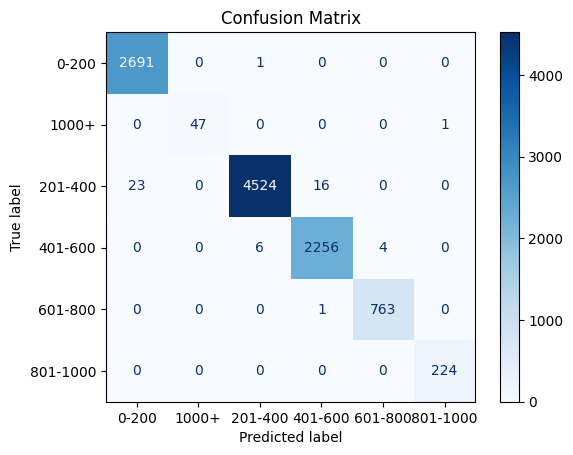

In [10]:
    # Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [11]:
# ROC AUC Score (commented out as in original)
try:
    y_pred_proba = xgb_model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted', labels=np.unique(y_test))
    print(f"ROC AUC Score (weighted 'ovr'): {roc_auc:.4f}")
except Exception as e:
    print(f"Could not calculate ROC AUC score: {e}")


ROC AUC Score (weighted 'ovr'): 1.0000


In [19]:
# --- Tambahkan di bagian "6. Evaluasi Model Performance" ---

print("\n--- 6. Evaluating Model Performance ---")
y_pred_train = xgb_model.predict(X_train) # Prediksi pada data training
y_pred_test = xgb_model.predict(X_test)   # Prediksi pada data testing

# Hitung akurasi untuk training dan testing
accuracy_train = (y_train == y_pred_train).mean()
accuracy_test = (y_test == y_pred_test).mean()

print(f"Accuracy on Training Set: {accuracy_train:.4f}")
print(f"Accuracy on Test Set: {accuracy_test:.4f}")

if accuracy_train > accuracy_test * 1.1:
    print("DIAGNOSA: POTENSI OVERFITTING! Akurasi training jauh lebih tinggi dari akurasi testing.")
else:
    print("DIAGNOSA: Akurasi training dan testing relatif seimbang. Potensi overfitting rendah.")



--- 6. Evaluating Model Performance ---
Accuracy on Training Set: 0.9980
Accuracy on Test Set: 0.9951
DIAGNOSA: Akurasi training dan testing relatif seimbang. Potensi overfitting rendah.


In [12]:
# --- 7. Saving Model and Objects ---
print("\n--- 7. Saving Model and Preprocessing Objects ---")
try:
    pickle.dump(xgb_model, open('xgb_model.pkl', 'wb'))
    with open('mlb.pkl', 'wb') as f:
        pickle.dump(mlb, f)
    with open('le.pkl', 'wb') as f:
        pickle.dump(le, f)
    # Save the exact feature columns used during training
    with open('model_input_feature_columns.pkl', 'wb') as f:
        pickle.dump(model_input_feature_columns, f)

    print("Model, MultiLabelBinarizer, LabelEncoder, and Model Input Feature Columns saved successfully.")
except Exception as e:
    print(f"Error saving objects: {e}")


--- 7. Saving Model and Preprocessing Objects ---
Model, MultiLabelBinarizer, LabelEncoder, and Model Input Feature Columns saved successfully.


In [13]:
# --- 8. Loading Model and Objects (for demonstration/usage) ---
print("\n--- 8. Loading Model and Preprocessing Objects ---")
try:
    loaded_model = pickle.load(open('xgb_model.pkl', 'rb'))
    with open('mlb.pkl', 'rb') as f:
        loaded_mlb = pickle.load(f)
    with open('le.pkl', 'rb') as f:
        loaded_le = pickle.load(f)
    with open('model_input_feature_columns.pkl', 'rb') as f:
        loaded_model_input_feature_columns = pickle.load(f)

    print("Model, MultiLabelBinarizer, LabelEncoder, and Model Input Feature Columns loaded successfully.")
    print(f"Loaded Model Input Feature Columns: {loaded_model_input_feature_columns[:5]}... ({len(loaded_model_input_feature_columns)} total)")

except Exception as e:
    print(f"Error loading objects: {e}. Please ensure you ran step 7 successfully.")
    exit() # Exit if loading fails, as the recommendation function depends on these.


--- 8. Loading Model and Preprocessing Objects ---
Model, MultiLabelBinarizer, LabelEncoder, and Model Input Feature Columns loaded successfully.
Loaded Model Input Feature Columns: ['CookTime', 'PrepTime', 'TotalTime', 'Calories', 'FatContent']... (280 total)


In [14]:
# --- 9. Recommendation Function ---
print("\n--- 9. Defining Recommendation Function ---")
def search_food_by_keywords(df, keywords, target_calories, top_n=5):
    """
    Recommends food items based on keywords and target calorie intake.

    Args:
        df (pd.DataFrame): The original DataFrame after initial column selection,
                           and 'Keywords' column renamed to 'tags'.
                           This is the `data` DataFrame from the main script after its initial
                           preprocessing steps (column selection and renaming 'Keywords' to 'tags').
        keywords (list): A list of strings (tags) to filter food items. Case-insensitive.
        target_calories (int): The user's desired calorie intake.
        top_n (int): The number of top recommendations to return.

    Returns:
        pd.DataFrame: A DataFrame with recommended food items, their original tags, calories,
                      and a prediction probability representing how well they align
                      with the target calorie bin given their features.
                      The output columns will be 'food', 'tags', 'calories', 'pred_prob'.
    """
    # Ensure keywords are lowercase for consistent matching
    keywords = [k.lower() for k in keywords]

    # --- Step 1: Filter DataFrame by keywords ---
    temp_df = df.copy() # Make a copy to avoid modifying the original 'data' DataFrame

    # The 'tags' column in `data` (and thus `temp_df`) is already a list of lowercase, stripped strings.
    # So, we can directly use it for `tags_cleaned`. No further `lower()` or `split(',')` is needed.
    temp_df['tags_cleaned'] = temp_df['tags'].copy()

    # Filter by user-provided keywords against the cleaned tags
    filtered_df = temp_df[temp_df['tags_cleaned'].apply(lambda x: any(k in x for k in keywords))].copy()

    if filtered_df.empty:
        print(f"No food found matching keywords: {keywords}")
        return pd.DataFrame(columns=['food', 'tags', 'calories', 'pred_prob'])

    # --- Step 2: Determine target calorie bin for prediction ---
    # Use the globally defined `bins` and `labels`
    target_calorie_label = None
    for i in range(len(bins) - 1):
        if bins[i] <= target_calories <= bins[i+1]:
            target_calorie_label = labels[i]
            break
    if target_calorie_label is None and target_calories > bins[-1]:
        target_calorie_label = labels[-1]
    elif target_calorie_label is None: # For values less than min bin
        target_calorie_label = labels[0]

    try:
        target_calorie_bin_encoded = loaded_le.transform([target_calorie_label])[0]
    except ValueError:
        print(f"Error: Target calorie label '{target_calorie_label}' not found in loaded LabelEncoder classes.")
        return pd.DataFrame(columns=['food', 'tags', 'calories', 'pred_prob'])

    # --- Step 3: Prepare features for model prediction ---
    # Re-apply MultiLabelBinarizer to the *cleaned* tags from the filtered_df
    filtered_keywords_encoded = loaded_mlb.transform(filtered_df['tags_cleaned'])
    filtered_keywords_df = pd.DataFrame(filtered_keywords_encoded, columns=loaded_mlb.classes_, index=filtered_df.index)

    # Create the prediction DataFrame (X_predict) with all required features in the correct order
    X_predict = pd.DataFrame(0, index=filtered_df.index, columns=loaded_model_input_feature_columns)

    # Define numerical_features again (consistent with section 4)
    numerical_features = [
        'CookTime', 'PrepTime', 'TotalTime', 'Calories', 'FatContent',
        'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
        'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
        'RecipeServings'
    ]

    # Populate numerical features
    for col in numerical_features:
        if col in filtered_df.columns and pd.api.types.is_numeric_dtype(filtered_df[col]):
            X_predict[col] = filtered_df[col]
        else:
            print(f"Warning: Numerical column '{col}' missing or not numeric in filtered DataFrame during prediction. Filling with 0.")
            # X_predict[col] is already 0, so no action needed beyond warning

    # Populate binarized tag features
    for col in loaded_mlb.classes_:
        if col in filtered_keywords_df.columns:
            X_predict[col] = filtered_keywords_df[col]
        # Else: X_predict[col] remains 0 if a tag column is not present for this food

    # --- Step 4: Predict probabilities ---
    pred_proba = loaded_model.predict_proba(X_predict)

    # Extract the probability for the specific target calorie bin for each food
    filtered_df['pred_prob'] = [prob[target_calorie_bin_encoded] for prob in pred_proba]

    # --- Step 5: Sort and select top results ---
    filtered_df = filtered_df.sort_values(by='pred_prob', ascending=False)

    # Return required columns, mapping 'Name' to 'food' and 'tags' to 'tags' (since it was renamed)
    return filtered_df[['Name', 'tags', 'Calories', 'pred_prob']].rename(
        columns={'Name': 'food'}
    ).head(top_n)


--- 9. Defining Recommendation Function ---


In [15]:
# --- 10. Example Usage ---
print("\n--- 10. Demonstrating Recommendation Function ---")
# Contoh penggunaan
user_input = ['High protein', 'asian', 'low calorie'] # ini dari keywords
user_input = [x.lower() for x in user_input]
target_calories = 1500

# Pass the `data` DataFrame that has the 'tags' column (renamed from 'Keywords')
result = search_food_by_keywords(data, user_input, target_calories, top_n=5)
display(result)


--- 10. Demonstrating Recommendation Function ---


,food,tags,Calories,pred_prob
9,Butterflied Lamb with Garlic Butter,"[meat, high protein, high in, weeknight, oven]",1195,0.999866
51541,Moroccan Roasted Chicken,"[chicken, poultry, meat, moroccan, african, hi...",1169,0.999863
18472,Teriyaki Chicken and Rice,"[chicken thigh leg, whole chicken, chicken, w...",1255,0.999852
40764,Patio Ribs,"[meat, asian, high protein, kid friendly, high...",1138,0.999850
9678,Oven Fried Bisquick Chicken,"[poultry, meat, high protein, high in, camping...",1135,0.999846


In [16]:
# Example with different keywords
user_input_2 = ['vegetarian', 'dessert']
user_input_2 = [x.lower() for x in user_input_2]
target_calories_2 = 400
result_2 = search_food_by_keywords(data, user_input_2, target_calories_2, top_n=3)
display(result_2)

,food,tags,Calories,pred_prob
1601,Butter Crunch Lemon-Cheese Bars,"[dessert, lunchsnacks, cookie brownie, fruit,...",293,0.999744
18523,Banana-Split Cheesecake,"[dessert, strawberry, pineapple, cheese, berri...",278,0.999744
51056,Light and Fluffy Baked Apple Pancake,"[dessert, apple, fruit, healthy, sweet, brunch...",274,0.999733


In [17]:
# --- Contoh 3: Resep sarapan cepat ---
print("\n--- Skenario 3: Resep Sarapan Cepat (Target 300 kcal) ---")
user_input_3 = ['quick', 'breakfast']
user_input_3 = [x.lower() for x in user_input_3]
target_calories_3 = 300
result_3 = search_food_by_keywords(data, user_input_3, target_calories_3, top_n=4)
display(result_3)


--- Skenario 3: Resep Sarapan Cepat (Target 300 kcal) ---


,food,tags,Calories,pred_prob
7401,Potato Focaccia,"[breads, breakfast, lunchsnacks, potato, veget...",275,0.999751
22737,Coffee-Cake Muffins,"[breads, breakfast, healthy, mins, oven]",256,0.999732
1751,Best Banana Bread Or Muffins,"[breads, breakfast, lunchsnacks, fruit, kid fr...",237,0.999731
5565,Banana Streusel Muffins,"[breads, breakfast, tropical fruits, fruit, he...",269,0.999729


In [18]:
data.shape

(52785, 18)